In [37]:
%load_ext autoreload
%autoreload 2

In [38]:
from __future__ import division, print_function

import collections
import csv
import datetime
import xml.etree.ElementTree as ET

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

from GlucNet_functions import *

In [39]:
filepath = f"../OhioT1DM/2018/train/559-ws-training.xml"
tree = ET.parse(filepath)
root = tree.getroot()
glucose = read_ohio(filepath, "glucose_level", False)

category is  glucose_level
length of root.findall(category) is  1


# Preprocessing

#### P1

In [40]:
glucose_dict = {entry[0]['ts']: entry[0]['value'] for entry in glucose}

# Create the multi-channel database
g_data = []
for timestamp in glucose_dict:
    record = {
        'timestamp': timestamp,
        'glucose_value': glucose_dict[timestamp],
        # 'meal_type': None,
        # 'meal_carbs': 0
    }
    
    g_data.append(record)
glucose_df = pd.DataFrame(g_data)

# Convert glucose values to numeric type for analysis
glucose_df['glucose_value'] = pd.to_numeric(glucose_df['glucose_value'])

# Calculate percentiles
lower_percentile = np.percentile(glucose_df['glucose_value'], 2)
upper_percentile = np.percentile(glucose_df['glucose_value'], 98)

# Print thresholds
print(f"2% lower threshold: {lower_percentile}")
print(f"98% upper threshold: {upper_percentile}")

2% lower threshold: 64.0
98% upper threshold: 337.0


### P2, P3

In [41]:
segments = segement_data_as_1hour(glucose_df)
interpolated_segements = detect_missing_and_spline_interpolate(segments)

segment_3
before:  2021-12-12 04:54:00
after:  2021-12-12 05:29:00
segment_3
before:  2021-12-12 12:34:00
after:  2021-12-12 12:44:00
segment_3
before:  2021-12-12 22:09:00
after:  2021-12-12 22:39:00
segment_7
before:  2021-12-16 17:53:00
after:  2021-12-16 18:18:00
segment_14
before:  2021-12-22 17:52:00
after:  2021-12-22 18:52:00
segment_14
before:  2021-12-24 17:52:00
after:  2021-12-24 18:32:00
segment_15
before:  2021-12-26 18:57:00
after:  2021-12-26 19:22:00
segment_18
before:  2022-01-01 20:50:00
after:  2022-01-01 21:10:00
segment_21
before:  2022-01-06 06:26:00
after:  2022-01-06 07:21:00
segment_25
before:  2022-01-08 18:05:00
after:  2022-01-08 18:40:00
segment_29
before:  2022-01-14 01:05:00
after:  2022-01-14 01:35:00
segment_31
before:  2022-01-16 19:11:00
after:  2022-01-16 19:56:00


\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:35: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_list = np.array(pd.date_range(start=min(segments[sequence]['timestamp']), end=max(segments[sequence]['timestamp']), freq='5T').tolist())
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:48: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index_interpolated = pd.date_range(start=reference_time, periods=len(interpolated_xs), freq='5T')


In [42]:
meal = read_ohio(filepath, "meal", False)

flattened_meal_data = [item[0] for item in meal]  # Take the first (and only) item from each sublist

# Convert to DataFrame
meal_df = pd.DataFrame(flattened_meal_data)

meal_df['assigned'] = False

meal_updated_segments = update_segments_with_meals(interpolated_segements, meal_df)


category is  meal
length of root.findall(category) is  1


\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:430: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '18' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:430: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '45' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  segment_df.at[i, 'carbs'] = closest_meal['carbs']
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:430: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '63' ha

In [43]:
basal = read_ohio(filepath, "basal", False)

flattened_basal_data = [item[0] for item in basal]  # Take the first (and only) item from each sublist

# Convert to DataFrame
basal_df = pd.DataFrame(flattened_basal_data)

basal_df['assigned'] = False
basal_df['end_ts'] = basal_df['ts'].shift(-1)
basal_df[:10]

category is  basal
length of root.findall(category) is  1


,ts,value,assigned,end_ts
0,2021-12-07 00:00:00,0.65,False,2021-12-07 04:00:00
1,2021-12-07 04:00:00,0.73,False,2021-12-07 08:00:00
2,2021-12-07 08:00:00,1.15,False,2021-12-07 11:00:00
3,2021-12-07 11:00:00,0.9,False,2021-12-08 00:00:00
4,2021-12-08 00:00:00,0.65,False,2021-12-08 04:00:00
5,2021-12-08 04:00:00,0.73,False,2021-12-08 08:00:00
6,2021-12-08 08:00:00,1.15,False,2021-12-08 11:00:00
7,2021-12-08 11:00:00,0.9,False,2021-12-08 18:00:00
8,2021-12-08 18:00:00,1.25,False,2021-12-11 00:00:00
9,2021-12-11 00:00:00,0.65,False,2021-12-11 04:00:00


In [44]:
# basal_updated_segments = update_segments_with_basal(meal_updated_segments, basal_df)


In [45]:
# # Merge Bolus into the dataframe
# bolus = read_ohio_bolus_tempbasal(filepath, "bolus", False)

# flattened_bolus_data = [item[0] for item in bolus]  # Take the first (and only) item from each sublist

# # Convert to DataFrame
# bolus_df = pd.DataFrame(flattened_bolus_data)

# bolus_df['assigned'] = False
# bolus_df[:10]

In [46]:
# bolus_updated_segments = update_segments_with_bolus(basal_updated_segments, bolus_df)

In [47]:
# tempbasal = read_ohio_bolus_tempbasal(filepath, "temp_basal", False)

In [48]:
# flattened_tempbasal_data = [item[0] for item in tempbasal]  # Take the first (and only) item from each sublist

# # Convert to DataFrame
# tempbasal_df = pd.DataFrame(flattened_tempbasal_data)

# tempbasal_df['assigned'] = False
# tempbasal_df[:10]

In [49]:


# # Update the segments with meal data
# final_updated_segments = update_segments_with_tempbasal(bolus_updated_segments, tempbasal_df)

# Training

In [50]:
import torch
from torch.utils.data import DataLoader, TensorDataset

In [92]:
def label_delta_transform(labels_list):
    # label_lower_percentile = -12.75
    # label_upper_percentile = 12.85
    label_lower_percentile = np.percentile(labels_list, 10)
    label_upper_percentile = np.percentile(labels_list, 90)
    transformed_labels = []
    for label in labels_list:
        if label <= label_lower_percentile:
            transformed_labels.append(1)
        elif label_lower_percentile < label < label_upper_percentile:
            trans_label = round((256/(label_upper_percentile - label_lower_percentile))*(label + abs(label_lower_percentile) + 0.05))
            transformed_labels.append(trans_label)
        elif label >= label_upper_percentile:
            transformed_labels.append(256)
    return transformed_labels


# def prepare_dataset(segments, ph):
#     '''
#     ph = 6, 30 minutes ahead
#     ph = 12, 60 minutes ahead
#     '''
#     features_list = []
#     labels_list = []
#     raw_glu_list = []
    
#     # Iterate over each segment
#     for segment_name, segment_df in segments.items():
#         # Ensure all columns are of numeric type
#         segment_df['carbs'] = pd.to_numeric(segment_df['carbs'], errors='coerce')
#         segment_df['basal_rate'] = pd.to_numeric(segment_df['basal_rate'], errors='coerce')
#         segment_df['bolus_dose'] = pd.to_numeric(segment_df['bolus_dose'], errors='coerce')

#         # Fill NaNs that might have been introduced by conversion errors
#         segment_df.fillna(0, inplace=True)

#         # Maximum index for creating a complete feature set
#         max_index = len(segment_df) - (15+ph+1)  # Subtracting 22 because we need to predict index + 21 and need index + 15 to exist
        
#         # Iterate through the data to create feature-label pairs
#         for i in range(max_index + 1):
#             # Extracting features from index i to i+15
#             features = segment_df.loc[i:i+15, ['glucose_value', 'carbs', 'basal_rate', 'bolus_dose']].values#.flatten()
#             # Extracting label for index i+21
#             # Do the label transform
#             label = segment_df.loc[i+15+ph, 'glucose_value'] - segment_df.loc[i+15, 'glucose_value']
            
#             raw_glu_list.append(segment_df.loc[i+15+ph, 'glucose_value'])
#             features_list.append(features)
#             labels_list.append(label)
            
#     print("len of features_list " + str(len(features_list)))
#     print("len of labels_list " + str(len(labels_list)))
#     new_labels_list = label_delta_transform(labels_list)    
#     print("after label transform. the len of label list "+str(len(new_labels_list)))    
#     return features_list, labels_list, new_labels_list, raw_glu_list

def prepare_dataset(segments,history_len = 6, ph = 6):
    '''
    ph = 6, 30 minutes ahead
    ph = 12, 60 minutes ahead
    '''
    features_list = []
    labels_list = []
    raw_glu_list = []
    
    
    # Iterate over each segment
    for segment_name, segment_df in segments.items():
        # Ensure all columns are of numeric type
        segment_df['carbs'] = pd.to_numeric(segment_df['carbs'], errors='coerce')
        segment_df['basal_rate'] = pd.to_numeric(segment_df['basal_rate'], errors='coerce')
        segment_df['bolus_dose'] = pd.to_numeric(segment_df['bolus_dose'], errors='coerce')

        # Fill NaNs that might have been introduced by conversion errors
        segment_df.fillna(0, inplace=True)

        # Maximum index for creating a complete feature set
        print("len of segment_df is ", len(segment_df))
        max_index = len(segment_df) - (history_len + ph)  # Subtracting only 15+ph to ensure i + 15 + ph is within bounds
        
        # Iterate through the data to create feature-label pairs
        for i in range(max_index):
            # Extracting features from index i to i+15
            segment_df = segment_df.reset_index(drop = True)
            features = segment_df.loc[i:i+history_len, ['glucose_value', 'carbs', 'bolus_dose']].values
            # Extracting label for index i+15+ph
            # label = segment_df.loc[i+15+ph, 'glucose_value'] - segment_df.loc[i+15, 'glucose_value']
            
            raw_glu_list.append(segment_df.loc[i+history_len+ph, 'glucose_value'])
            features_list.append(features)
            # labels_list.append(label)
            
    print("len of features_list " + str(len(features_list)))
    # print("len of labels_list " + str(len(labels_list)))
    
    # new_labels_list = label_delta_transform(labels_list)    
    # print("after label transform, the len of label list "+str(len(new_labels_list)))    
    
    return features_list, raw_glu_list


In [76]:
# load train data from the .pkl file
import pickle
file_num = 'all'
HISTORY = 12

with open(f'./pkl_files/559_train_combined_segments_wavenet.pkl', 'rb') as f:
    final_updated_segments= pickle.load(f)


features_list, labels_list = prepare_dataset(final_updated_segments, HISTORY)

FileNotFoundError: [Errno 2] No such file or directory: './pkl_files/559_train_combined_segments_wavenet.pkl'

In [ ]:
test

NameError: name 'final_updated_segments' is not defined

In [77]:
features_array = np.array(features_list)
labels_array = np.array(labels_list)

# Step 1: Split into 80% train+val and 20% test
X_temp, X_test, y_temp, y_test = train_test_split(features_array, labels_array, test_size=0.2, shuffle=False)

# Step 2: Split the 80% into 70% train and 10% val (0.7/0.8 = 0.875)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.125, shuffle=False)

# Convert the splits to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

NameError: name 'features_list' is not defined

In [ ]:
# Convert lists to PyTorch tensors
features_tensor = torch.tensor(features_list, dtype=torch.float32)
labels_tensor = torch.tensor(labels_list, dtype=torch.float32).unsqueeze(1)  # Making labels tensor 2D

feature_label_tensor = TensorDataset(features_tensor, labels_tensor)


train_loader = DataLoader(feature_label_tensor, batch_size=32, shuffle=True)

# Example of using DataLoader in a training loop
for features, labels in train_loader:
    print("Features batch shape:", features.shape)
    print("Label batch shape:", labels.shape)
    # Example: print(features, labels)
    break

Features batch shape: torch.Size([32, 13, 4])
Label batch shape: torch.Size([32, 1])


In [78]:
# initialize cuda option
dtype = torch.FloatTensor # data type
ltype = torch.LongTensor # label type

use_cuda = torch.cuda.is_available()
if use_cuda:
    print('use gpu')
    dtype = torch.cuda.FloatTensor
    ltype = torch.cuda.LongTensor

use gpu


In [79]:
# Build the dilate CNN
import torch
import torch.nn as nn
import torch.nn.functional as F

class WaveNetBlock(nn.Module):
    def __init__(self, in_channels, dilation):
        super(WaveNetBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, in_channels, kernel_size=2, dilation=dilation, padding=1+dilation - 2^(dilation-1))
        self.conv2 = nn.Conv1d(in_channels, in_channels, kernel_size=2, dilation=dilation, padding=dilation)
        self.res_conv = nn.Conv1d(in_channels, in_channels, kernel_size=1)
        
    def forward(self, x):
        # print("shape of x: ", x.shape)
        out = F.relu(self.conv1(x))
        # print("shape of first out: ", out.shape)
        out = F.relu(self.conv2(out))
        # print("shape of second out: ", out.shape)
        res = self.res_conv(x)
        # print("shape of res: ", res.shape)
        return out + res

class WaveNet(nn.Module):
    def __init__(self, in_channels, out_channels, num_blocks, dilations):
        super(WaveNet, self).__init__()
        self.initial_conv = nn.Conv1d(in_channels, 32, kernel_size=2, padding=1)
        self.blocks = nn.ModuleList([WaveNetBlock(32, dilation) for dilation in dilations])
        self.final_conv1 = nn.Conv1d(32, 128, kernel_size=2, padding=0)
        self.final_conv2 = nn.Conv1d(128, 256, kernel_size=2, padding=0)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, out_channels)
        
    def forward(self, x):
        x = F.relu(self.initial_conv(x))
        for block in self.blocks:
            # print("enter the block loop")
            x = block(x)
        x = F.relu(self.final_conv1(x))
        x = F.relu(self.final_conv2(x))
        x = x[:, :, -1]  # Get the last time step
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

input_channels = 3  # Number of features
output_channels = 1  # Predicting a single value (glucose level)
num_blocks = 4  # Number of WaveNet blocks
dilations = [2**i for i in range(num_blocks)]  # Dilation rates: 1, 2, 4, 8

model = WaveNet(input_channels, output_channels, num_blocks, dilations)

# Example of how to define the loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)


In [80]:
for inputs, targets in train_loader:
    print("Input tensor shape:", inputs.shape)
    print("Input tensor total elements:", inputs.numel())
    print("Target tensor shape:", targets.shape)
    print("Sequence length:", inputs.shape[1])
    break


NameError: name 'train_loader' is not defined

In [81]:

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.permute(0, 2, 1))  # Permute to match (batch, channels, seq_len)
        outputs = outputs.squeeze()  # Remove extra dimensions if present
        targets = targets.squeeze()  # Remove extra dimensions if present

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs.permute(0, 2, 1))  # Permute to match (batch, channels, seq_len)
            outputs = outputs.squeeze()  # Remove extra dimensions if present
            targets = targets.squeeze()  # Remove extra dimensions if present

            loss = criterion(outputs, targets)
            val_loss += loss.item()
    
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss / len(val_loader)}')

NameError: name 'train_loader' is not defined

In [82]:
# save model
torch.save(model, f'./glucnet_model_{file_num}_H_{HISTORY}.pth')

In [83]:
from GlucNet_functions import *

In [94]:
def prepare_dataset_test_dataset( file_dir, HISTORY = 6):
        # test data
    g_data = []

    print("file_dir is ", file_dir)
    test_file_path = file_dir 
    test_glucose = read_ohio(test_file_path, "glucose_level", False)
    test_glucose_dict = {entry[0]['ts']: entry[0]['value'] for entry in test_glucose}

    for timestamp in test_glucose_dict:
        record = {
            'timestamp': timestamp,
            'glucose_value': test_glucose_dict[timestamp],
        }
        
        g_data.append(record)
    test_glucose_df = pd.DataFrame(g_data)
    test_glucose_df['glucose_value'] = pd.to_numeric(test_glucose_df['glucose_value'])

    test_segmebts = segement_data_as_1hour(test_glucose_df)
    test_interpolated_segments = detect_missing_and_spline_interpolate(test_segmebts)

    test_meal = read_ohio(test_file_path, "meal", False)
    flattened_test_meal_data = [item[0] for item in test_meal]  # Take the first (and only) item from each sublist
    test_meal_df = pd.DataFrame(flattened_test_meal_data)
    test_meal_df['assigned'] = False
    test_meal_updated_segments = update_segments_with_meals(test_interpolated_segments, test_meal_df)

    test_basal = read_ohio(test_file_path, "basal", False)
    flattened_test_basal_data = [item[0] for item in test_basal]  # Take the first (and only) item from each sublist
    test_basal_df = pd.DataFrame(flattened_test_basal_data)
    test_basal_df['assigned'] = False
    test_basal_df['end_ts'] = test_basal_df['ts'].shift(-1)
    test_basal_updated_segments = update_segments_with_basal(test_meal_updated_segments, test_basal_df)

    test_bolus = read_ohio_bolus_tempbasal(test_file_path, "bolus", False)
    flattened_test_bolus_data = [item[0] for item in test_bolus]  # Take the first (and only) item from each sublist
    test_bolus_df = pd.DataFrame(flattened_test_bolus_data)
    test_bolus_df['assigned'] = False
    test_bolus_updated_segments = update_segments_with_bolus(test_basal_updated_segments, test_bolus_df)

    # test_tempbasal = read_ohio_bolus_tempbasal(test_file_path, "temp_basal", False)
    # flattened_test_tempbasal_data = [item[0] for item in test_tempbasal]  # Take the first (and only) item from each sublist
    # test_tempbasal_df = pd.DataFrame(flattened_test_tempbasal_data)
    # test_tempbasal_df['assigned'] = False

    # test_final_updated_segments = update_segments_with_tempbasal(test_bolus_updated_segments, test_tempbasal_df)
    test_features_list, test_labels_list = prepare_dataset(test_bolus_updated_segments, HISTORY)

    test_features_array = np.array(test_features_list)
    test_labels_array = np.array(test_labels_list)

    X_test, y_test = torch.tensor(test_features_array, dtype=torch.float32), torch.tensor(test_labels_array, dtype=torch.float32)

    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    return test_loader



In [95]:
# # load the model 
# input_channels = 4  # Number of features
# output_channels = 1
# num_blocks = 4  # Number of WaveNet blocks
# dilations = [2**i for i in range(num_blocks)]  # Dilation rates: 1, 2, 4, 8
# model = WaveNet(input_channels, output_channels, num_blocks, dilations)
# # # PH = 12
# # file_num = 'all'

# # model.load_state_dict(torch.load(f'./glucnet_model_100_epoch_ph12.pth'))

In [96]:
test_loader

In [87]:
filename = './BIG_training_data.pkl'
with open(filename
          , 'rb') as f:
    test_final_updated_segments = pickle.load(f)
    

# rename the bolus_effect to bolus_ds

In [88]:
# test_loader = prepare_dataset_test_dataset(test_filename, HISTORY)
# test

In [89]:
model = torch.load(f'./glucnet_model_OHIO_ALL_FEATURES_ALL_H_7.pth')


C:\Users\Biratal\AppData\Local\Temp\ipykernel_142904\2482611198.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f'./glucnet_model_OHIO_ALL_FEATURES_AL

In [100]:
import glob




preds = []
trues = []
errors = []
fname = []
HISTORY = 7

for file in glob.glob("../OhioT1DM/2018_test/*.xml"):
    test_filename = file
    test_loader = prepare_dataset_test_dataset(test_filename, HISTORY)
    # Verify the content
    # Calculate RMSE on test set
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs.permute(0, 2, 1))
            predictions.append(outputs)
            actuals.append(targets)
            
    predictions = torch.cat(predictions).cpu().numpy()
    actuals = torch.cat(actuals).cpu().numpy()

    rmse = np.sqrt(mean_squared_error(actuals,predictions))
    print(f'RMSE on test set: {rmse}')



    preds.append(predictions)
    trues.append(actuals)
    errors.append(rmse)
    fname.append(test_filename.split('-ws')[0][-3:])


file_dir is  ../OhioT1DM/2018_test\559-ws-testing.xml
category is  glucose_level
length of root.findall(category) is  1
segment_1
before:  2022-01-18 17:06:00
after:  2022-01-18 18:06:00
segment_3
before:  2022-01-21 16:32:00
after:  2022-01-21 16:47:00
segment_5
before:  2022-01-23 20:12:00
after:  2022-01-23 20:32:00


\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:35: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_list = np.array(pd.date_range(start=min(segments[sequence]['timestamp']), end=max(segments[sequence]['timestamp']), freq='5T').tolist())
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:48: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index_interpolated = pd.date_range(start=reference_time, periods=len(interpolated_xs), freq='5T')


category is  meal
length of root.findall(category) is  1


\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:430: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '46' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  closest_meal = meal_df.loc[meal_df['time_difference'].idxmin()]
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:430: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '40' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  closest_meal = meal_df.loc[meal_df['time_difference'].idxmin()]
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:430: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future vers

category is  basal
length of root.findall(category) is  1


\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:321: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  closest_bolus = bolus_df.loc[bolus_df['time_difference'].idxmin()]
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:321: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.9' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  closest_bolus = bolus_df.loc[bolus_df['time_difference'].idxmin()]
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:321: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a fut

len of segment_df is  499
len of segment_df is  239
len of segment_df is  367
len of segment_df is  162
len of segment_df is  510
len of segment_df is  283
len of segment_df is  142
len of segment_df is  96
len of segment_df is  232
len of features_list 2413
RMSE on test set: 20.69158581725462
file_dir is  ../OhioT1DM/2018_test\563-ws-testing.xml
category is  glucose_level
length of root.findall(category) is  1
segment_2
before:  2021-11-05 10:18:00
after:  2021-11-05 10:38:00
segment_2
before:  2021-11-06 03:38:00
after:  2021-11-06 03:48:00
category is  meal
length of root.findall(category) is  1


\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:35: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_list = np.array(pd.date_range(start=min(segments[sequence]['timestamp']), end=max(segments[sequence]['timestamp']), freq='5T').tolist())
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:48: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index_interpolated = pd.date_range(start=reference_time, periods=len(interpolated_xs), freq='5T')
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:430: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  closes

category is  basal
length of root.findall(category) is  1


\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:321: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '6.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  closest_bolus = bolus_df.loc[bolus_df['time_difference'].idxmin()]
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:321: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  closest_bolus = bolus_df.loc[bolus_df['time_difference'].idxmin()]


len of segment_df is  848
len of segment_df is  1726
len of features_list 2548
RMSE on test set: 19.337959963673537
file_dir is  ../OhioT1DM/2018_test\570-ws-testing.xml
category is  glucose_level
length of root.findall(category) is  1
segment_1
before:  2022-01-17 06:39:00
after:  2022-01-17 06:59:00
segment_1
before:  2022-01-18 05:49:00
after:  2022-01-18 06:39:00
segment_2
before:  2022-01-21 17:09:00
after:  2022-01-21 18:04:00
segment_2
before:  2022-01-22 08:04:00
after:  2022-01-22 08:44:00
segment_2
before:  2022-01-23 06:44:00
after:  2022-01-23 07:29:00
segment_4
before:  2022-01-26 17:17:00
after:  2022-01-26 17:37:00
category is  meal
length of root.findall(category) is  1


\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:35: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_list = np.array(pd.date_range(start=min(segments[sequence]['timestamp']), end=max(segments[sequence]['timestamp']), freq='5T').tolist())
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:48: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index_interpolated = pd.date_range(start=reference_time, periods=len(interpolated_xs), freq='5T')
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:430: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '60' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  closes

category is  basal
length of root.findall(category) is  1


\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:430: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '150' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  closest_meal = meal_df.loc[meal_df['time_difference'].idxmin()]


Unequal: begin: 2022-01-17 07:23:45 end: 2022-01-17 07:53:45
Unequal: begin: 2022-01-17 12:04:02 end: 2022-01-17 12:34:02
Unequal: begin: 2022-01-17 19:45:45 end: 2022-01-17 20:45:45
Unequal: begin: 2022-01-18 07:14:27 end: 2022-01-18 07:44:27
Unequal: begin: 2022-01-18 12:09:25 end: 2022-01-18 12:39:25
Unequal: begin: 2022-01-18 19:06:47 end: 2022-01-18 19:36:47
Unequal: begin: 2022-01-19 07:03:53 end: 2022-01-19 07:33:53
Unequal: begin: 2022-01-19 11:44:39 end: 2022-01-19 12:14:39
Unequal: begin: 2022-01-19 16:43:34 end: 2022-01-19 17:13:34
Unequal: begin: 2022-01-19 19:13:28 end: 2022-01-19 19:43:28
Unequal: begin: 2022-01-20 07:00:39 end: 2022-01-20 07:30:39
Unequal: begin: 2022-01-20 11:57:00 end: 2022-01-20 12:27:00
Unequal: begin: 2022-01-20 14:40:03 end: 2022-01-20 15:10:03
Unequal: begin: 2022-01-20 18:29:00 end: 2022-01-20 18:59:00
Unequal: begin: 2022-01-21 06:12:20 end: 2022-01-21 06:42:20
Unequal: begin: 2022-01-21 20:15:04 end: 2022-01-21 21:15:04
Unequal: begin: 2022-01-

\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:321: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  closest_bolus = bolus_df.loc[bolus_df['time_difference'].idxmin()]
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:321: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '9.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  closest_bolus = bolus_df.loc[bolus_df['time_difference'].idxmin()]
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:321: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a fut

len of segment_df is  651
len of segment_df is  1550
len of segment_df is  69
len of segment_df is  515
len of features_list 2733
RMSE on test set: 17.482348449914237
file_dir is  ../OhioT1DM/2018_test\575-ws-testing.xml
category is  glucose_level
length of root.findall(category) is  1
segment_1
before:  2022-01-04 07:00:00
after:  2022-01-04 07:30:00
segment_2
before:  2022-01-05 19:25:00
after:  2022-01-05 19:45:00
segment_2
before:  2022-01-06 07:25:00
after:  2022-01-06 08:10:00
segment_3
before:  2022-01-07 19:35:00
after:  2022-01-07 20:05:00
segment_3
before:  2022-01-08 07:50:00
after:  2022-01-08 08:40:00
segment_4
before:  2022-01-09 06:44:00
after:  2022-01-09 07:29:00
segment_4
before:  2022-01-10 07:14:00
after:  2022-01-10 07:29:00
category is  meal
length of root.findall(category) is  1


\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:35: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_list = np.array(pd.date_range(start=min(segments[sequence]['timestamp']), end=max(segments[sequence]['timestamp']), freq='5T').tolist())
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:48: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index_interpolated = pd.date_range(start=reference_time, periods=len(interpolated_xs), freq='5T')
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:430: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '40' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  closes

category is  basal
length of root.findall(category) is  1


\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:321: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  closest_bolus = bolus_df.loc[bolus_df['time_difference'].idxmin()]
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:321: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.8' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  closest_bolus = bolus_df.loc[bolus_df['time_difference'].idxmin()]
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:321: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a fut

len of segment_df is  808
len of segment_df is  760
len of segment_df is  240
len of segment_df is  822
len of features_list 2578
RMSE on test set: 22.73428774682569
file_dir is  ../OhioT1DM/2018_test\588-ws-testing.xml
category is  glucose_level
length of root.findall(category) is  1
category is  meal
length of root.findall(category) is  1


\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:430: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  closest_meal = meal_df.loc[meal_df['time_difference'].idxmin()]
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:430: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '50' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  closest_meal = meal_df.loc[meal_df['time_difference'].idxmin()]
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:430: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future vers

category is  basal
length of root.findall(category) is  1


\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:321: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.7' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  closest_bolus = bolus_df.loc[bolus_df['time_difference'].idxmin()]
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:321: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.9' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  closest_bolus = bolus_df.loc[bolus_df['time_difference'].idxmin()]
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:321: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a fut

len of segment_df is  401
len of segment_df is  1649
len of segment_df is  741
len of features_list 2752
RMSE on test set: 19.791423381180167
file_dir is  ../OhioT1DM/2018_test\591-ws-testing.xml
category is  glucose_level
length of root.findall(category) is  1
segment_2
before:  2022-01-20 05:29:00
after:  2022-01-20 05:44:00
segment_2
before:  2022-01-20 17:29:00
after:  2022-01-20 17:49:00


\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:35: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  datetime_list = np.array(pd.date_range(start=min(segments[sequence]['timestamp']), end=max(segments[sequence]['timestamp']), freq='5T').tolist())
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:48: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index_interpolated = pd.date_range(start=reference_time, periods=len(interpolated_xs), freq='5T')


category is  meal
length of root.findall(category) is  1


\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:430: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '32' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  closest_meal = meal_df.loc[meal_df['time_difference'].idxmin()]
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:430: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '57' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  closest_meal = meal_df.loc[meal_df['time_difference'].idxmin()]
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:430: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future vers

category is  basal
length of root.findall(category) is  1


\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:321: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.0' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  closest_bolus = bolus_df.loc[bolus_df['time_difference'].idxmin()]
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:321: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '5.0' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  closest_bolus = bolus_df.loc[bolus_df['time_difference'].idxmin()]
\\dartfs-hpc\rc\home\j\f007g3j\ReproducibilityStudy_DL_BGPrediction\GluNet_Again\GlucNet_functions.py:321: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a fut

len of segment_df is  388
len of segment_df is  1536
len of segment_df is  841
len of features_list 2726
RMSE on test set: 22.01171077805978


In [102]:
curr_dat = pd.DataFrame({'fname': fname, 'rmse': errors})
curr_dat

,fname,rmse
0,559,20.691586
1,563,19.337960
2,570,17.482348
3,575,22.734288
4,588,19.791423
5,591,22.011711


In [ ]:
curr_dat = pd.DataFrame({'fname': fname, 'rmse': errors})
curr_dat.to_csv(f'wavenet_ph_{PH}_{file_num}.csv', index=False)

In [103]:
# print curr_dat without the index
# make it copy pasteable into an excel 
curr_dat.to_clipboard(index=False, header=False)

In [ ]:
curr_dat

,fname,rmse
0,559,34.685474
1,563,31.599613
2,570,29.892048
3,575,37.283928
4,588,38.189610
5,591,36.195969


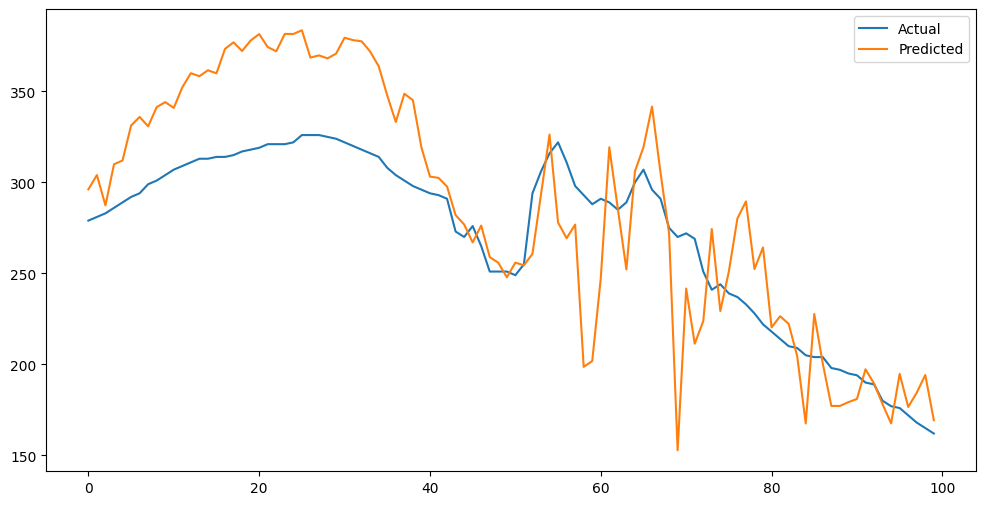

In [ ]:
# plot the prediction
plt.figure(figsize=(12, 6))
plt.plot(trues[0][:100], label='Actual')
plt.plot(preds[0][:100], label='Predicted')
plt.legend()



In [ ]:
# load all the data from the csv files
df_list = []
for file in glob.glob('./wavenet_ph_12*.csv'):
    temp = pd.read_csv(file)
    temp['trained on'] = file.split('_')[-1].split('.')[0]
    df_list.append(temp)
# combine all the data into one dataframe

df = pd.concat(df_list)
# pivot on trained on 
df = df.pivot(index='fname', columns='trained on', values='rmse') 
df

trained on,559,563,570,575,588,591,all
fname,,,,,,,
559,36.410465,35.225582,33.402462,38.371143,39.093662,39.255234,34.685474
563,40.276314,33.883686,30.473051,47.027763,39.698074,42.574295,31.599613
570,40.084854,38.631165,27.280270,42.094067,38.522625,52.839590,29.892048
575,40.853190,38.751957,36.972176,39.794506,38.433556,44.562910,37.283928
588,37.908150,34.175060,32.602142,39.382870,33.703064,38.442844,38.189610
591,42.047100,37.478480,36.900790,38.473194,39.823467,37.858353,36.195970


In [ ]:
# get the average of the columns
df['mean'] = df.mean(axis=0)

df['559'].mean()

39.596678833333335